In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.config import paths, params


cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

In [3]:
import json

CONFIG_PATH = os.path.join('cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/config1.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

print(inference_list)
print(ranges)

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '1000s_y1Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'summ_stats1.npz')  # LFP and labels

summ_stats   = np.load(LFP_PATH)['x']
labels = np.load(LFP_PATH)['y']

df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
display(df_la)

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
{'x': [-50, 50], 'y': [-1410, 1410], 'z': [20.0, 200.0], 'alpha': [0, 3.141592653589793], 'h': [-1.0, 1.0], 'phi': [-3.141592653589793, 3.141592653589793], 'd': [20.0, 200.0], 'theta': [-1.0471975511965976, 1.0471975511965976], 'r_s': [7.0, 12.0], 'l_t': [20.0, 800.0], 'r_t': [0.6, 1.8], 'r_d': [0.1, 0.8], 'r_tu': [0.1, 0.8], 'l_d': [100.0, 300.0]}


,y,d,theta,h,phi,r_s,l_t,r_t
627,-1410.0,41.511921,-0.158994,0.045184,1.795346,10.876466,60.323855,1.339792
209,-1390.0,82.193870,0.153615,0.207046,-0.587714,7.482669,633.318327,0.806964
281,-1390.0,153.552669,0.757685,0.266829,1.564203,11.355899,633.143779,1.542288
319,-1390.0,26.251297,0.333190,-0.060911,2.560302,11.662128,174.852211,0.998163
339,-1390.0,107.898000,0.619971,0.995207,2.594179,7.523900,467.485806,1.387055
...,...,...,...,...,...,...,...,...
922,1390.0,48.701186,-0.528297,-0.066698,1.073151,9.627685,267.824601,1.450782
874,1390.0,117.055572,0.136667,0.033821,1.700699,10.108020,76.314990,1.546085
694,1390.0,188.656656,-0.343167,0.870631,-3.120249,10.378971,748.244669,0.728380
872,1390.0,172.972956,-0.118490,-0.459225,1.172503,11.608390,638.314068,1.571085


In [4]:
labels[:,0] = np.load(LFP_PATH)['ys']
ranges['y'] = [-100, 100]

for i in range(labels.shape[1]):
    label = labels[:, i]
    label_name = inference_list[i]
    min_max_range = ranges[label_name]
    x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
    x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    labels[:, i] = x_scaled
df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
display(df_la)

,y,d,theta,h,phi,r_s,l_t,r_t
627,-1.000000,-0.760979,-0.151828,0.045184,0.571476,0.550586,-0.896605,0.232986
209,-0.985816,-0.308957,0.146692,0.207046,-0.187075,-0.806932,0.572611,-0.655060
281,-0.985816,0.483919,0.723536,0.266829,0.497901,0.742360,0.572164,0.570480
319,-0.985816,-0.930541,0.318173,-0.060911,0.814970,0.864851,-0.602943,-0.336394
339,-0.985816,-0.023356,0.592029,0.995207,0.825753,-0.790440,0.147400,0.311758
...,...,...,...,...,...,...,...,...
922,0.985816,-0.681098,-0.504487,-0.066698,0.341595,0.051074,-0.364552,0.417971
874,0.985816,0.078395,0.130508,0.033821,0.541349,0.243208,-0.855603,0.576809
694,0.985816,0.873963,-0.327700,0.870631,-0.993206,0.351589,0.867294,-0.786033
872,0.985816,0.699700,-0.113150,-0.459225,0.373219,0.843356,0.585421,0.618475


In [5]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch


model = FullyConnectedNetwork(in_features=40, out_features=8)
PATH = 'cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.helperfunctions import build_dataloader_from_numpy

device = torch.device("cpu")

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model.eval()
x = x.to(device)
output = model(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print("R2: {}".format(r2_score(y, output)))

print(output.shape)
print(y.shape)

(991, 40)
(991, 8)
R2: 0.51718824287451
(128, 8)
(128, 8)


In [7]:
print(y.shape)
print(output[:,0])

if True:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out



(128, 8)


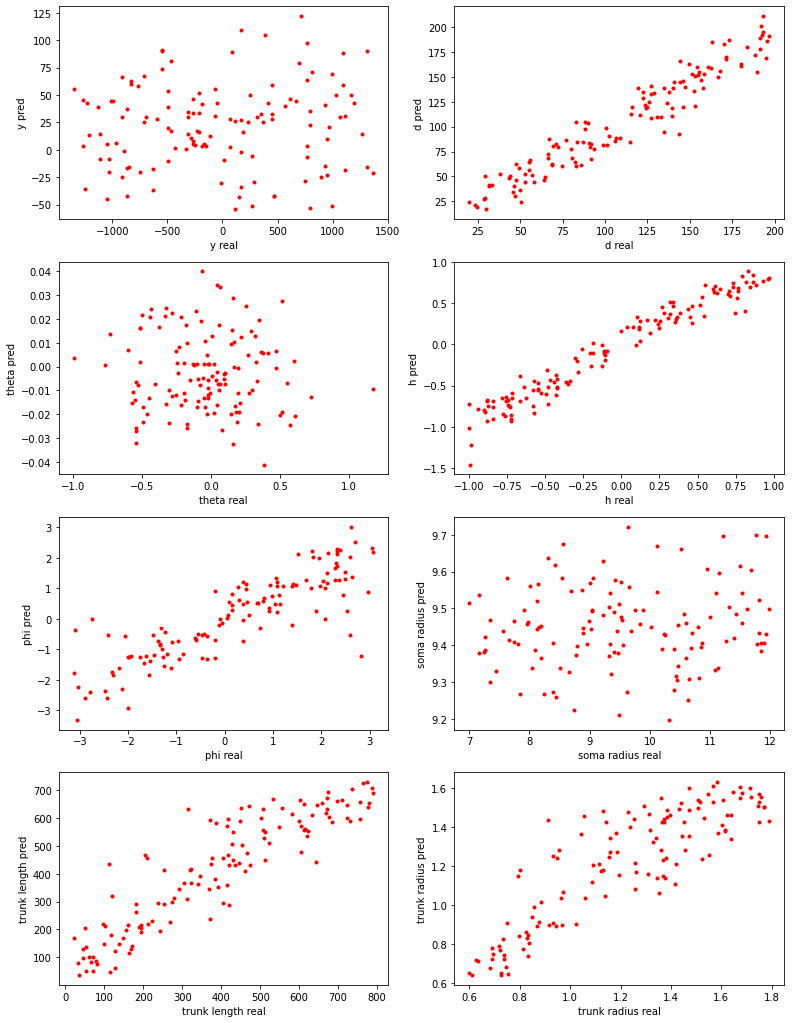

In [8]:
%matplotlib inline

idx = 0

plt.figure(figsize=(13,18))

ax_y = plt.subplot(421)
ax_y.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_y.set_xlabel('y real')
ax_y.set_ylabel('y pred')

ax_d = plt.subplot(422)
ax_d.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(423)
ax_t.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(424)
ax_h.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(425)
ax_p.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(428)
ax_lt.scatter(y[:,7], output[:,7], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [9]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window
from tqdm.notebook import tqdm
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    c = f['coord'][:]
    d = f['data'][:]  # time x channels x samples

t = np.arange(d.shape[0])



filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                                       params.FILTER_CRITICAL_FREQUENCY,
                                       params.BANDFILTER_TYPE,
                                       fs=params.FILTER_SAMPLING_RATE)

# filtered_lfp = signal.lfilter(filt_b, filt_a, d, axis=1)  # filter along time axis
filtered_lfp = d

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(d.shape[2]):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[:,:,i])
    start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[start:end, :, i])

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

print(windowed_lfp.shape)

test_data = []
summ_stats = []
bad_indices = []
y_pos = []
for i in tqdm(range(windowed_lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(windowed_lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        # windowed_lfp = np.delete(windowed_lfp, i, axis=0)
        # self.labels = np.delete(self.labels, i, axis=0)
        bad_indices.append(i)
        continue
    test_data.append(g_lfp)
    summ_stats.append(calculate_stats(g_lfp))
    y_pos.append(y_i)
    
test_data = np.stack(test_data, axis=0)
summ_stats = np.array(summ_stats)
y_pos = np.stack(y_pos, axis=0)

(383, 176, 384)


  0%|          | 0/383 [00:00<?, ?it/s]

In [10]:
y_pos = y_pos.reshape((-1, 1))

np.set_printoptions(suppress=True)

model.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

pred[:,0] = y_pos - pred[:, 0]

print(pred.shape)

if True:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred


y_pred = pred
df = pd.DataFrame(y_pred, columns=inference_list).sort_values(by='y')
display(df)

(359, 8)


,y,d,theta,h,phi,r_s,l_t,r_t
226,518.524048,-757.148987,1.061079,0.033175,-40.873589,9.593012,901.755554,5.878338
227,533.333984,-735.532776,1.005256,1.371931,-38.259983,9.467223,554.137024,5.623046
46,546.154175,-723.245605,1.133201,0.999548,-43.689980,9.572828,409.087646,6.221037
139,566.218140,-787.976440,1.074407,1.618583,-41.174889,9.493811,696.693298,5.952234
228,566.411499,-768.528748,1.065491,1.670327,-40.518749,9.466816,483.073822,5.882972
...,...,...,...,...,...,...,...,...
215,3582.250000,-5237.402832,7.505971,-0.476624,-288.071411,11.644509,5134.849121,33.393406
136,3619.759766,-5302.034668,7.578402,-0.530332,-290.853790,11.669388,5262.499512,33.701050
325,3676.375488,-5407.673828,7.628507,-0.686754,-292.107666,11.640619,5385.795898,33.836418
22,4188.072754,-6227.263672,8.343512,-0.664396,-316.159424,11.598675,6013.172852,36.515987


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t
226,518.524048,-757.148987,1.061079,0.033175,-40.873589,9.593012,901.755554,5.878338
227,533.333984,-735.532776,1.005256,1.371931,-38.259983,9.467223,554.137024,5.623046
46,546.154175,-723.245605,1.133201,0.999548,-43.689980,9.572828,409.087646,6.221037
139,566.218140,-787.976440,1.074407,1.618583,-41.174889,9.493811,696.693298,5.952234
228,566.411499,-768.528748,1.065491,1.670327,-40.518749,9.466816,483.073822,5.882972
145,576.278931,-719.595642,1.151376,2.404599,-44.419201,9.505184,147.968399,6.338777
304,579.635620,-793.944519,1.126138,1.275604,-42.990086,9.519098,558.321289,6.148260
23,581.308350,-802.525269,1.105213,1.608492,-42.245579,9.496664,636.416321,6.072210
182,581.681396,-808.804749,1.312859,-0.010466,-51.428364,9.747939,838.245483,7.054565
144,582.428589,-817.035828,1.160141,1.323761,-44.908844,9.570971,832.961975,6.359783


(49, 176)
(49,)
(176,)


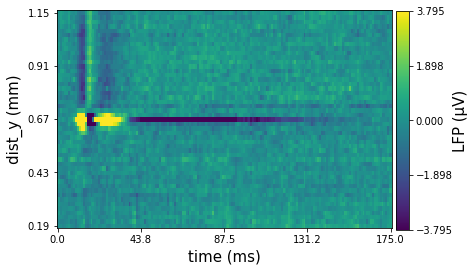

In [12]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

print(test_data[0,:,e_idx].shape)
print(g_coords[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     g_coords[e_idx, 1],
                     np.transpose(test_data[0,:,e_idx]), vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)

/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/utils/plotting/plot_all_cells.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'], df['z'] = pol2cart(df['d'], df['theta'])


<IPython.core.display.Javascript object>


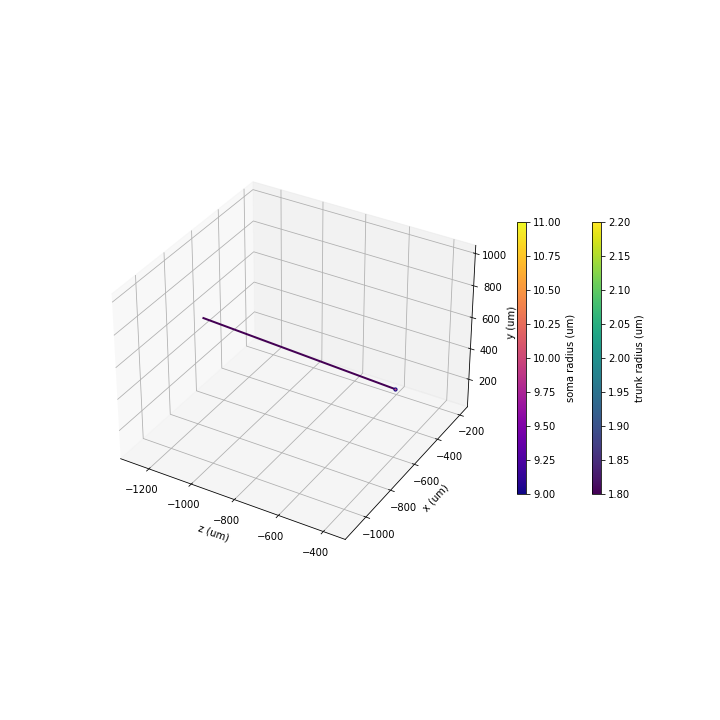

(<Figure size 720x720 with 3 Axes>,
 <Axes3DSubplot:xlabel='z (um)', ylabel='x (um)'>)

In [15]:
%matplotlib notebook

from cell_inference.utils.plotting.plot_all_cells import plot_all_cells

plot_all_cells(df.iloc[[0]], figsize=(10., 10.))